# CAD多视图图像编码器教程

本教程展示如何使用基于ViT的多视图图像编码器处理CAD零件图像。

## 目标
- 了解多视图ViT编码器的架构
- 学习如何处理三视图CAD图像
- 掌握特征提取和融合方法
- 实践不同的数据增强策略

## 1. 环境设置和导入

In [1]:
import sys
import os
from pathlib import Path

# 添加项目根目录到路径
project_root = Path(os.getcwd()).parent
sys.path.insert(0, str(project_root))

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 项目模块
from src.models.encoders.image_encoder import MultiViewViTEncoder, ImagePreprocessor
from src.data.transforms import create_train_transform, create_val_transform
from config.model_config import ModelConfig

# 设置matplotlib中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("环境设置完成!")
print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA可用: {torch.cuda.is_available()}")

环境设置完成!
PyTorch版本: 2.1.0+cu121
CUDA可用: True


## 2. 创建测试数据

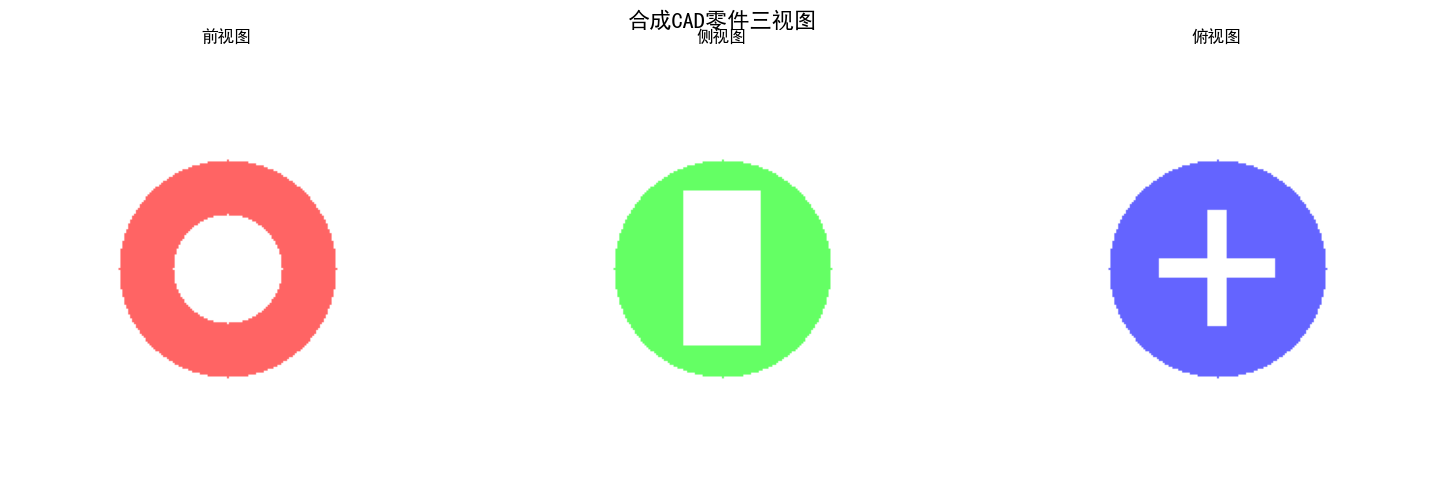

In [2]:
def create_synthetic_cad_images(num_views=3, size=(224, 224)):
    """创建合成的CAD零件图像"""
    images = []
    view_names = ["前视图", "侧视图", "俯视图"]
    colors = [(255, 100, 100), (100, 255, 100), (100, 100, 255)]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i in range(num_views):
        # 创建基础图像
        img_array = np.ones((*size, 3), dtype=np.uint8) * 255
        color = colors[i]
        
        # 添加几何形状模拟CAD零件
        center_x, center_y = size[0] // 2, size[1] // 2
        
        # 主体形状（圆形）
        y, x = np.ogrid[:size[0], :size[1]]
        mask = (x - center_x) ** 2 + (y - center_y) ** 2 <= (size[0] // 4) ** 2
        img_array[mask] = color
        
        # 添加特征（矩形孔）
        if i == 0:  # 前视图 - 圆形孔
            hole_mask = (x - center_x) ** 2 + (y - center_y) ** 2 <= (size[0] // 8) ** 2
            img_array[hole_mask] = [255, 255, 255]
        elif i == 1:  # 侧视图 - 矩形槽
            slot_x1, slot_x2 = center_x - 20, center_x + 20
            slot_y1, slot_y2 = center_y - 40, center_y + 40
            img_array[slot_y1:slot_y2, slot_x1:slot_x2] = [255, 255, 255]
        else:  # 俯视图 - 十字形特征
            # 水平线
            img_array[center_y-5:center_y+5, center_x-30:center_x+30] = [255, 255, 255]
            # 垂直线
            img_array[center_y-30:center_y+30, center_x-5:center_x+5] = [255, 255, 255]
        
        # 转换为PIL图像
        pil_image = Image.fromarray(img_array)
        images.append(pil_image)
        
        # 显示图像
        axes[i].imshow(img_array)
        axes[i].set_title(f"{view_names[i]}")
        axes[i].axis('off')
    
    plt.suptitle("合成CAD零件三视图", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return images

# 创建测试图像
test_images = create_synthetic_cad_images()

## 3. 初始化图像编码器

In [3]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 创建配置
config = ModelConfig()

# 创建图像编码器
encoder = MultiViewViTEncoder(
    model_name="vit_base_patch16_224",
    num_views=3,
    feature_dim=768,
    fusion_method="attention",
    dropout=0.1
).to(device)

print(f"编码器创建完成")
print(f"模型参数数量: {sum(p.numel() for p in encoder.parameters()):,}")
print(f"可训练参数: {sum(p.numel() for p in encoder.parameters() if p.requires_grad):,}")

使用设备: cuda
Backbone output shape: torch.Size([1, 197, 768]) -> processed: torch.Size([1, 197]), feature dim: 197
编码器创建完成
模型参数数量: 86,247,937
可训练参数: 86,247,937


## 4. 图像预处理

预处理后图像形状: torch.Size([3, 3, 224, 224])
数据范围: [-0.405, 2.640]


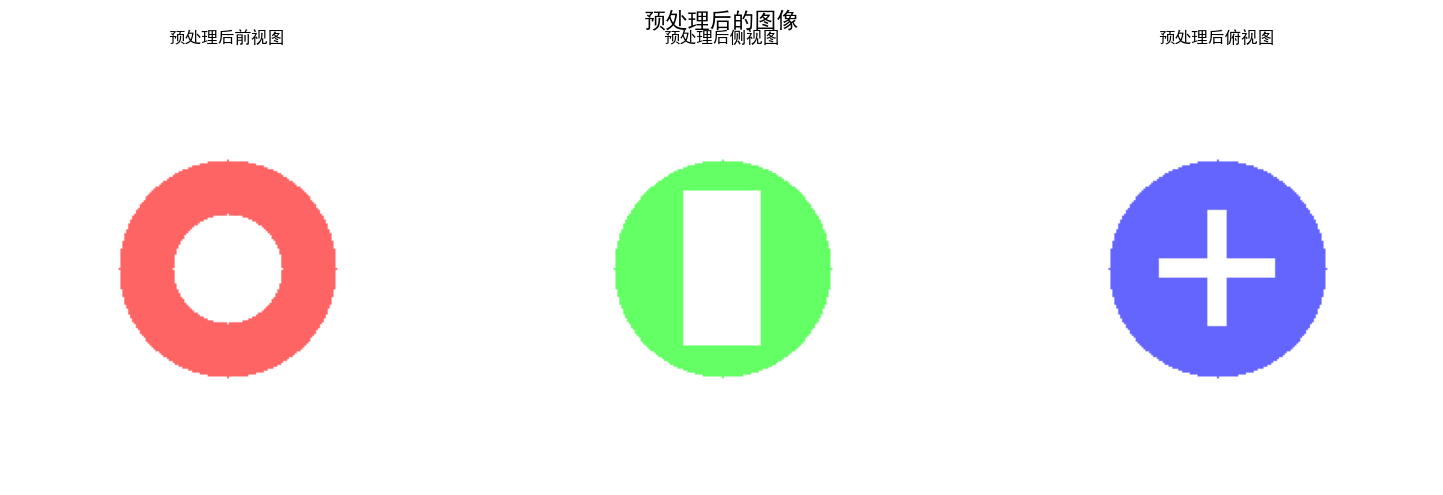

In [4]:
# 创建预处理器
preprocessor = ImagePreprocessor(
    image_size=(224, 224),
    augment=False
)

# 预处理图像
processed_images = preprocessor(test_images)  # [3, 3, 224, 224]
print(f"预处理后图像形状: {processed_images.shape}")
print(f"数据范围: [{processed_images.min():.3f}, {processed_images.max():.3f}]")

# 可视化预处理后的图像
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """反归一化用于可视化"""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
view_names = ["前视图", "侧视图", "俯视图"]

for i in range(3):
    # 反归一化
    img_tensor = processed_images[i].clone()
    img_tensor = denormalize(img_tensor)
    img_tensor = torch.clamp(img_tensor, 0, 1)
    
    # 转换为numpy并显示
    img_np = img_tensor.permute(1, 2, 0).numpy()
    axes[i].imshow(img_np)
    axes[i].set_title(f"预处理后{view_names[i]}")
    axes[i].axis('off')

plt.suptitle("预处理后的图像", fontsize=16)
plt.tight_layout()
plt.show()

## 5. 特征提取

In [5]:
# 准备批处理数据
batch_images = processed_images.unsqueeze(0).to(device)  # [1, 3, 3, 224, 224]
print(f"批处理图像形状: {batch_images.shape}")

# 特征提取
encoder.eval()
with torch.no_grad():
    outputs = encoder(batch_images)

# 输出结果分析
print("\n特征提取结果:")
print(f"融合特征形状: {outputs['fused_features'].shape}")
print(f"视图特征形状: {outputs['view_features'].shape}")

# 各视图特征
for view_name, feature in outputs['individual_features'].items():
    if feature is not None:
        print(f"{view_name}特征形状: {feature.shape}")

# 特征统计
fused_features = outputs['fused_features']
print(f"\n融合特征统计:")
print(f"均值: {fused_features.mean().item():.4f}")
print(f"标准差: {fused_features.std().item():.4f}")
print(f"范围: [{fused_features.min().item():.4f}, {fused_features.max().item():.4f}]")

批处理图像形状: torch.Size([1, 3, 3, 224, 224])

特征提取结果:
融合特征形状: torch.Size([1, 768])
视图特征形状: torch.Size([1, 3, 768])
front_view特征形状: torch.Size([1, 768])
side_view特征形状: torch.Size([1, 768])
top_view特征形状: torch.Size([1, 768])

融合特征统计:
均值: 0.0000
标准差: 0.9985
范围: [-2.5619, 2.6910]


## 6. 特征可视化分析

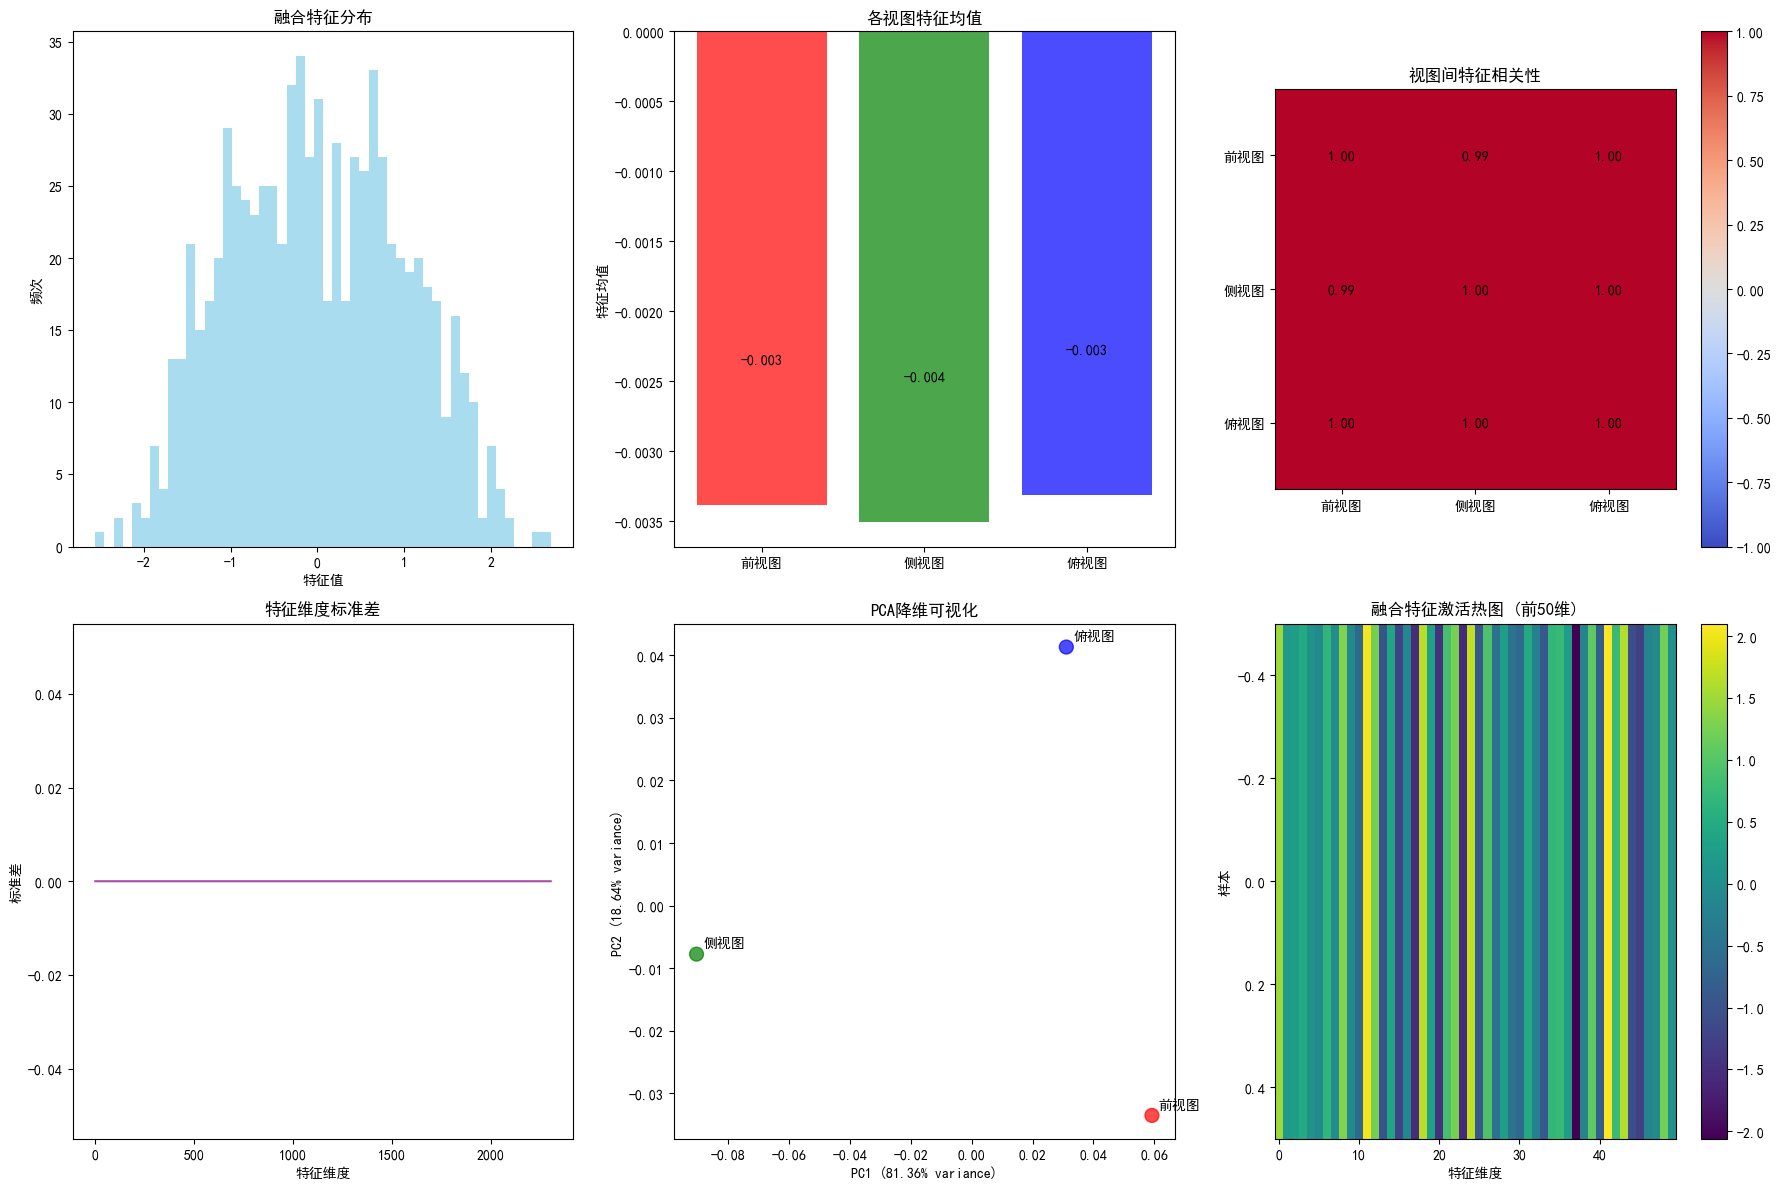

In [6]:
# 特征分布可视化
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. 融合特征分布
fused_features_np = outputs['fused_features'].cpu().numpy().flatten()
axes[0, 0].hist(fused_features_np, bins=50, alpha=0.7, color='skyblue')
axes[0, 0].set_title("融合特征分布")
axes[0, 0].set_xlabel("特征值")
axes[0, 0].set_ylabel("频次")

# 2. 各视图特征均值对比
view_features_np = outputs['view_features'].cpu().numpy()  # [1, 3, 768]
view_means = view_features_np.mean(axis=2).flatten()  # [3]
view_names = ["前视图", "侧视图", "俯视图"]
colors = ['red', 'green', 'blue']

bars = axes[0, 1].bar(view_names, view_means, color=colors, alpha=0.7)
axes[0, 1].set_title("各视图特征均值")
axes[0, 1].set_ylabel("特征均值")

# 添加数值标签
for bar, value in zip(bars, view_means):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                   f'{value:.3f}', ha='center', va='bottom')

# 3. 视图间相关性
individual_features = torch.stack([
    outputs['individual_features']['front_view'],
    outputs['individual_features']['side_view'],
    outputs['individual_features']['top_view']
]).cpu().numpy()  # [3, 1, 768]

correlation_matrix = np.corrcoef(individual_features.reshape(3, -1))
im = axes[0, 2].imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
axes[0, 2].set_title("视图间特征相关性")
axes[0, 2].set_xticks(range(3))
axes[0, 2].set_yticks(range(3))
axes[0, 2].set_xticklabels(view_names)
axes[0, 2].set_yticklabels(view_names)

# 添加相关性数值
for i in range(3):
    for j in range(3):
        text = axes[0, 2].text(j, i, f'{correlation_matrix[i, j]:.2f}',
                              ha="center", va="center", color="black")

plt.colorbar(im, ax=axes[0, 2])

# 4. 特征维度方差分析
feature_std = view_features_np.std(axis=0).flatten()  # [768]
axes[1, 0].plot(feature_std, color='purple', alpha=0.7)
axes[1, 0].set_title("特征维度标准差")
axes[1, 0].set_xlabel("特征维度")
axes[1, 0].set_ylabel("标准差")

# 5. PCA降维可视化
from sklearn.decomposition import PCA

# 对各视图特征进行PCA
pca = PCA(n_components=2)
view_features_2d = pca.fit_transform(individual_features.reshape(3, -1))

scatter = axes[1, 1].scatter(view_features_2d[:, 0], view_features_2d[:, 1], 
                           c=colors, s=100, alpha=0.7)
axes[1, 1].set_title("PCA降维可视化")
axes[1, 1].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
axes[1, 1].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")

# 添加标签
for i, name in enumerate(view_names):
    axes[1, 1].annotate(name, (view_features_2d[i, 0], view_features_2d[i, 1]),
                       xytext=(5, 5), textcoords='offset points')

# 6. 特征激活热图
# 显示融合特征的前50个维度
feature_heatmap = fused_features_np[:50].reshape(1, -1)
im = axes[1, 2].imshow(feature_heatmap, cmap='viridis', aspect='auto')
axes[1, 2].set_title("融合特征激活热图 (前50维)")
axes[1, 2].set_xlabel("特征维度")
axes[1, 2].set_ylabel("样本")
plt.colorbar(im, ax=axes[1, 2])

plt.tight_layout()
plt.show()

## 7. 不同融合方法对比

测试不同融合方法:
--------------------------------------------------

测试 attention 融合方法...
Backbone output shape: torch.Size([1, 197, 768]) -> processed: torch.Size([1, 197]), feature dim: 197
  输出形状: torch.Size([1, 768])
  特征均值: -0.0000
  特征标准差: 0.9983

测试 average 融合方法...
Backbone output shape: torch.Size([1, 197, 768]) -> processed: torch.Size([1, 197]), feature dim: 197
  输出形状: torch.Size([1, 768])
  特征均值: 0.0000
  特征标准差: 0.9984

测试 max 融合方法...
Backbone output shape: torch.Size([1, 197, 768]) -> processed: torch.Size([1, 197]), feature dim: 197
  输出形状: torch.Size([1, 768])
  特征均值: 0.0000
  特征标准差: 0.9983

测试 concat 融合方法...
Backbone output shape: torch.Size([1, 197, 768]) -> processed: torch.Size([1, 197]), feature dim: 197
  输出形状: torch.Size([1, 768])
  特征均值: -0.0000
  特征标准差: 0.9953


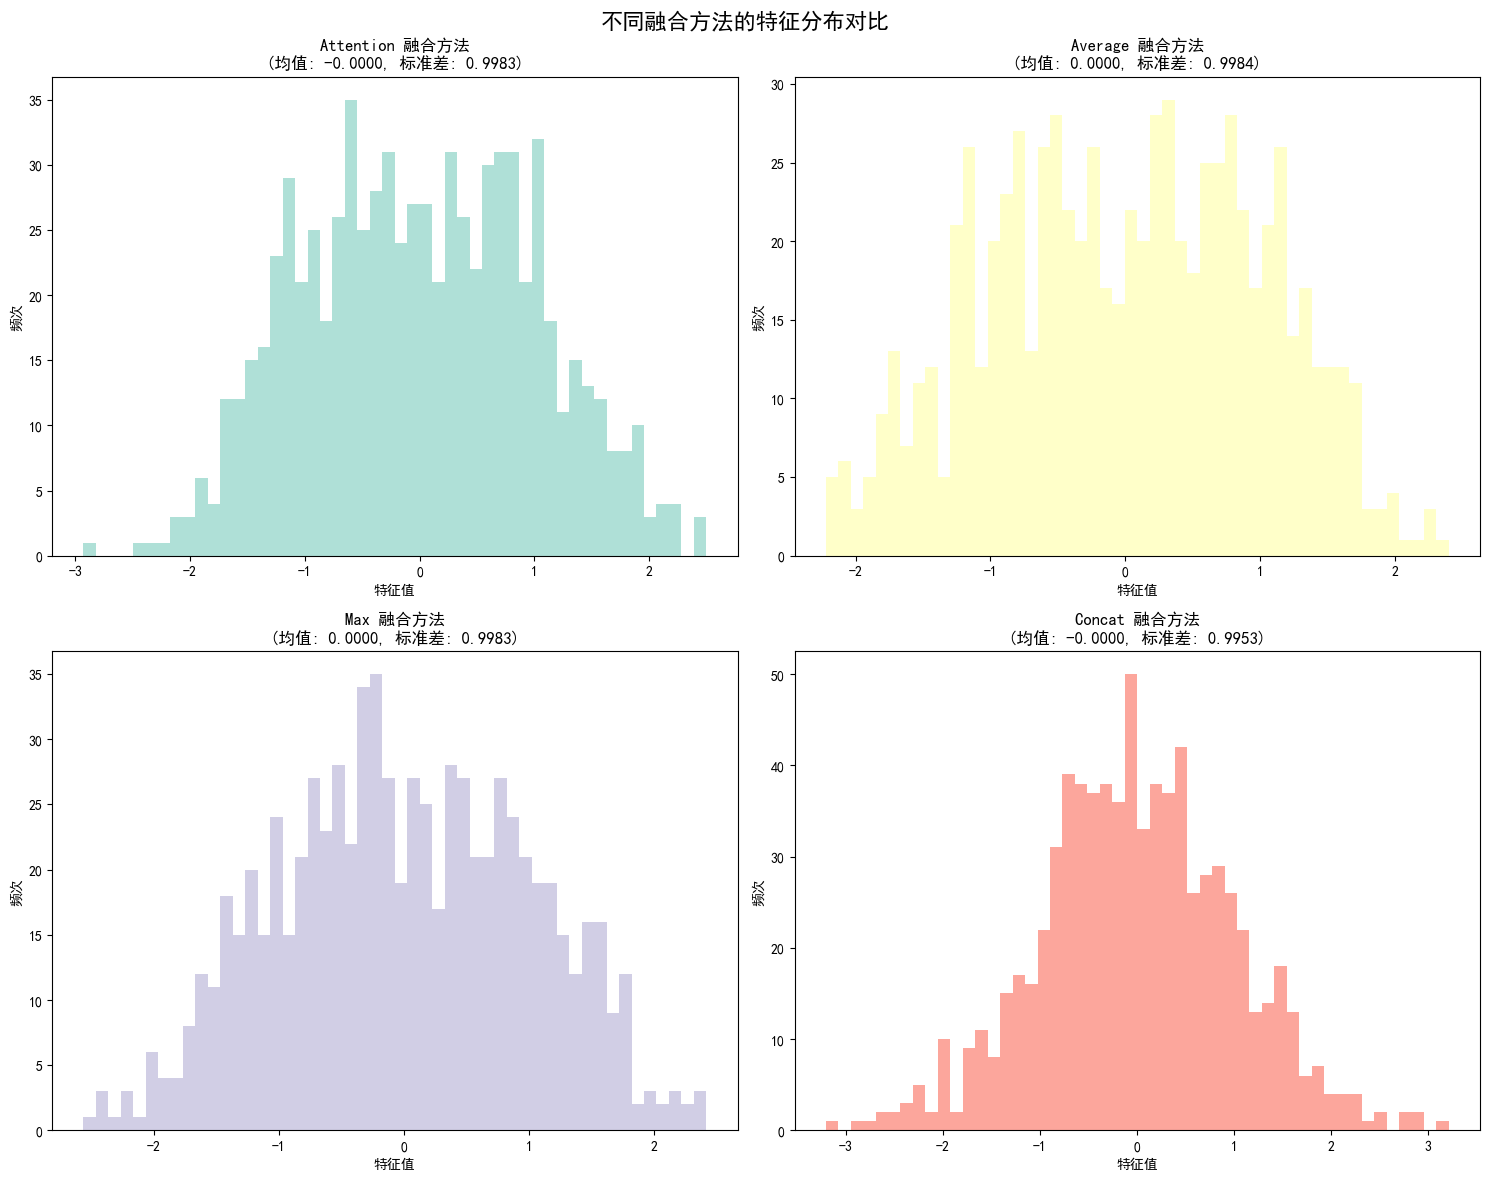


融合方法对比:
          方法   均值     标准差
0  attention -0.0  0.9983
1    average  0.0  0.9984
2        max  0.0  0.9983
3     concat -0.0  0.9953


In [7]:
# 测试不同的融合方法
fusion_methods = ["attention", "average", "max", "concat"]
fusion_results = {}

print("测试不同融合方法:")
print("-" * 50)

for method in fusion_methods:
    print(f"\n测试 {method} 融合方法...")
    
    # 创建编码器
    test_encoder = MultiViewViTEncoder(
        model_name="vit_base_patch16_224",
        num_views=3,
        feature_dim=768,
        fusion_method=method
    ).to(device)
    
    # 前向传播
    test_encoder.eval()
    with torch.no_grad():
        test_outputs = test_encoder(batch_images)
    
    fused_features = test_outputs['fused_features']
    fusion_results[method] = {
        "shape": fused_features.shape,
        "mean": fused_features.mean().item(),
        "std": fused_features.std().item(),
        "features": fused_features.cpu().numpy()
    }
    
    print(f"  输出形状: {fused_features.shape}")
    print(f"  特征均值: {fused_features.mean().item():.4f}")
    print(f"  特征标准差: {fused_features.std().item():.4f}")

# 可视化融合方法对比
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (method, result) in enumerate(fusion_results.items()):
    features = result["features"].flatten()
    axes[i].hist(features, bins=50, alpha=0.7, color=plt.cm.Set3(i))
    axes[i].set_title(f"{method.capitalize()} 融合方法\n(均值: {result['mean']:.4f}, 标准差: {result['std']:.4f})")
    axes[i].set_xlabel("特征值")
    axes[i].set_ylabel("频次")

plt.suptitle("不同融合方法的特征分布对比", fontsize=16)
plt.tight_layout()
plt.show()

# 融合方法统计对比
comparison_data = {
    "方法": list(fusion_results.keys()),
    "均值": [result["mean"] for result in fusion_results.values()],
    "标准差": [result["std"] for result in fusion_results.values()]
}

import pandas as pd
df = pd.DataFrame(comparison_data)
print("\n融合方法对比:")
print(df.round(4))

## 8. 数据增强效果测试

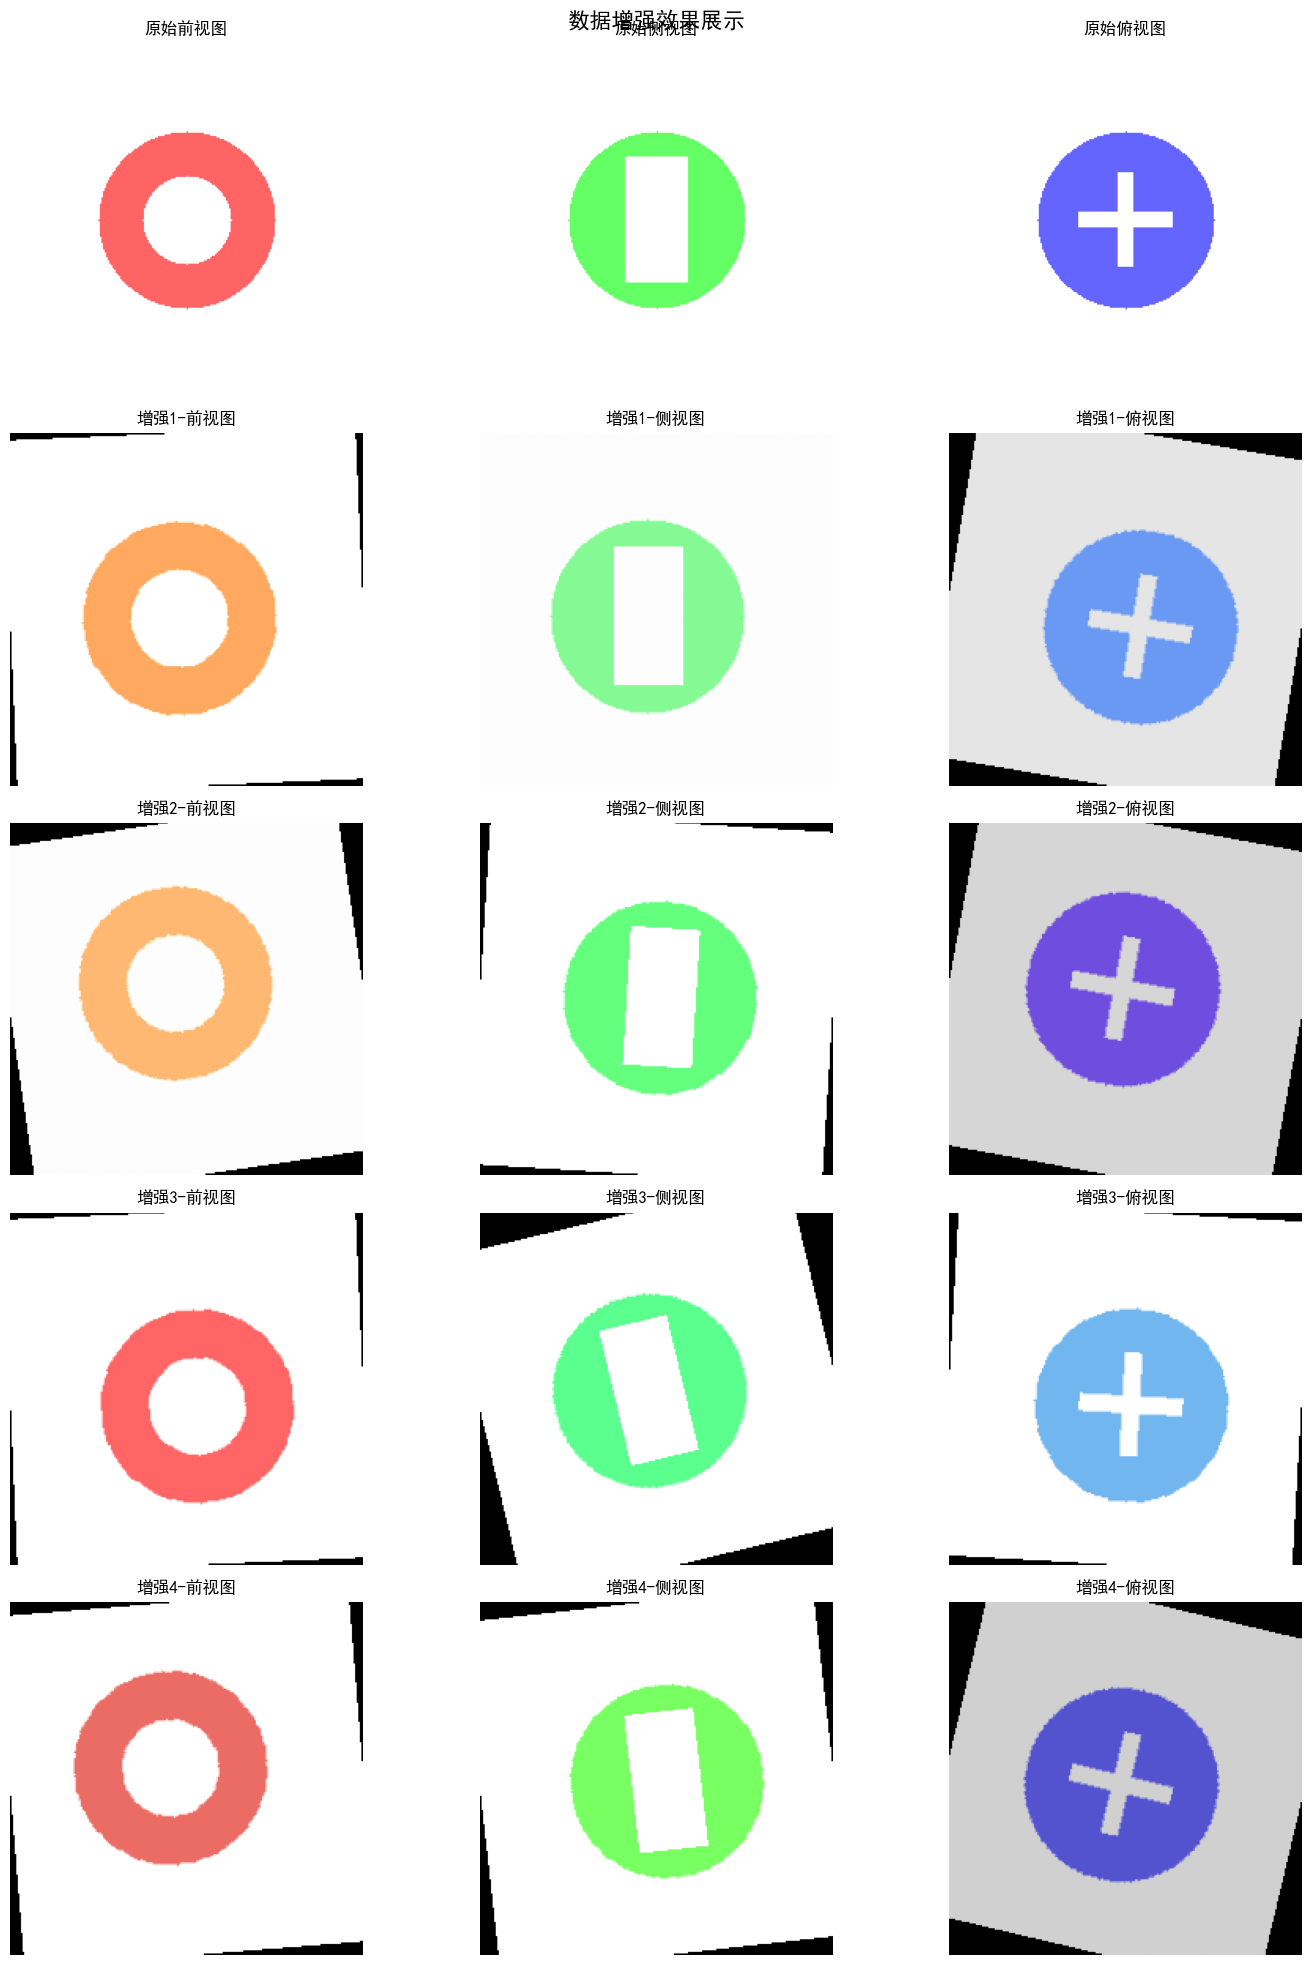


数据增强对特征提取的影响:
--------------------------------------------------
原始图像特征: 均值=0.0000, 标准差=0.9985
增强1特征: 均值=0.0000, 标准差=0.9984
    与原始特征相似度: 0.9948
增强2特征: 均值=-0.0000, 标准差=0.9984
    与原始特征相似度: 0.9953
增强3特征: 均值=0.0000, 标准差=0.9984
    与原始特征相似度: 0.9944
增强4特征: 均值=-0.0000, 标准差=0.9983
    与原始特征相似度: 0.9949

增强间特征一致性（标准差均值）: 0.0656


In [8]:
# 创建带增强的预处理器
augment_preprocessor = ImagePreprocessor(
    image_size=(224, 224),
    augment=True
)

# 生成多个增强版本
num_augmentations = 4
augmented_images = []

for i in range(num_augmentations):
    aug_images = augment_preprocessor(test_images)
    augmented_images.append(aug_images)

# 可视化增强效果
fig, axes = plt.subplots(num_augmentations + 1, 3, figsize=(15, 20))

# 原始图像
original_processed = preprocessor(test_images)
for j in range(3):
    img_tensor = original_processed[j].clone()
    img_tensor = denormalize(img_tensor)
    img_tensor = torch.clamp(img_tensor, 0, 1)
    img_np = img_tensor.permute(1, 2, 0).numpy()
    
    axes[0, j].imshow(img_np)
    axes[0, j].set_title(f"原始{view_names[j]}")
    axes[0, j].axis('off')

# 增强图像
for i, aug_images in enumerate(augmented_images):
    for j in range(3):
        img_tensor = aug_images[j].clone()
        img_tensor = denormalize(img_tensor)
        img_tensor = torch.clamp(img_tensor, 0, 1)
        img_np = img_tensor.permute(1, 2, 0).numpy()
        
        axes[i+1, j].imshow(img_np)
        axes[i+1, j].set_title(f"增强{i+1}-{view_names[j]}")
        axes[i+1, j].axis('off')

plt.suptitle("数据增强效果展示", fontsize=16)
plt.tight_layout()
plt.show()

# 分析增强对特征的影响
print("\n数据增强对特征提取的影响:")
print("-" * 50)

original_batch = original_processed.unsqueeze(0).to(device)
encoder.eval()
with torch.no_grad():
    original_output = encoder(original_batch)
    original_features = original_output['fused_features']

print(f"原始图像特征: 均值={original_features.mean().item():.4f}, 标准差={original_features.std().item():.4f}")

aug_features_list = []
for i, aug_images in enumerate(augmented_images):
    aug_batch = aug_images.unsqueeze(0).to(device)
    with torch.no_grad():
        aug_output = encoder(aug_batch)
        aug_features = aug_output['fused_features']
    
    aug_features_list.append(aug_features)
    print(f"增强{i+1}特征: 均值={aug_features.mean().item():.4f}, 标准差={aug_features.std().item():.4f}")
    
    # 计算与原始特征的相似度
    similarity = torch.cosine_similarity(original_features, aug_features)
    print(f"    与原始特征相似度: {similarity.item():.4f}")

# 特征一致性分析
all_features = torch.cat([original_features] + aug_features_list, dim=0)  # [5, 768]
feature_std_across_augs = all_features.std(dim=0).mean().item()
print(f"\n增强间特征一致性（标准差均值）: {feature_std_across_augs:.4f}")

## 9. 性能基准测试

运行性能基准测试...

测试批大小: 1
  平均时间: 0.0103±0.0005s
  吞吐量: 97.56 samples/s

测试批大小: 4
  平均时间: 0.0380±0.0009s
  吞吐量: 105.40 samples/s

测试批大小: 8
  平均时间: 0.0746±0.0017s
  吞吐量: 107.30 samples/s

测试批大小: 16
  平均时间: 0.1533±0.0031s
  吞吐量: 104.35 samples/s


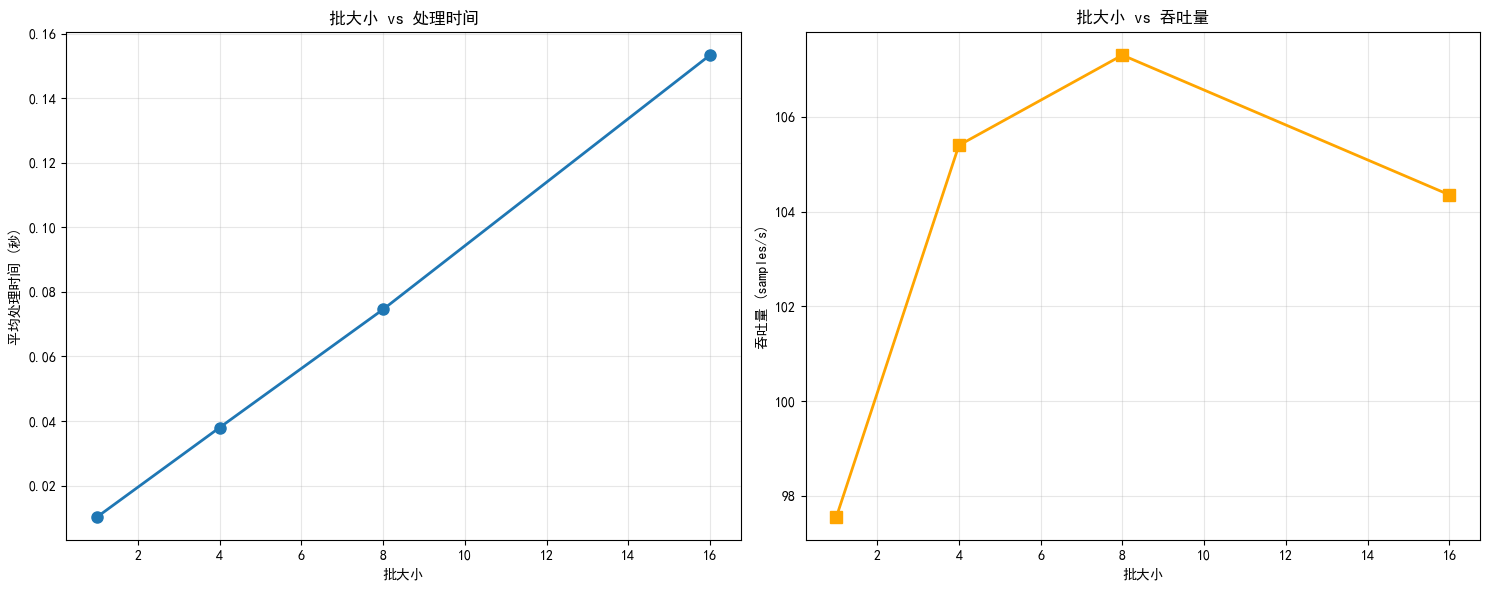


GPU内存使用:
已分配: 678.7 MB
已缓存: 1666.0 MB


In [9]:
import time

def benchmark_encoder(encoder, batch_sizes=[1, 4, 8, 16], num_runs=10):
    """基准测试编码器性能"""
    results = {}
    
    encoder.eval()
    
    for batch_size in batch_sizes:
        print(f"\n测试批大小: {batch_size}")
        
        # 创建测试数据
        test_batch = torch.randn(batch_size, 3, 3, 224, 224).to(device)
        
        # 预热
        with torch.no_grad():
            for _ in range(3):
                _ = encoder(test_batch)
        
        # 同步GPU
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        
        # 计时测试
        times = []
        for _ in range(num_runs):
            start_time = time.time()
            
            with torch.no_grad():
                outputs = encoder(test_batch)
            
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            
            end_time = time.time()
            times.append(end_time - start_time)
        
        avg_time = np.mean(times)
        std_time = np.std(times)
        throughput = batch_size / avg_time
        
        results[batch_size] = {
            "avg_time": avg_time,
            "std_time": std_time,
            "throughput": throughput
        }
        
        print(f"  平均时间: {avg_time:.4f}±{std_time:.4f}s")
        print(f"  吞吐量: {throughput:.2f} samples/s")
    
    return results

# 运行基准测试
print("运行性能基准测试...")
benchmark_results = benchmark_encoder(encoder)

# 可视化性能结果
batch_sizes = list(benchmark_results.keys())
avg_times = [benchmark_results[bs]["avg_time"] for bs in batch_sizes]
throughputs = [benchmark_results[bs]["throughput"] for bs in batch_sizes]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 处理时间
ax1.plot(batch_sizes, avg_times, 'o-', linewidth=2, markersize=8)
ax1.set_xlabel("批大小")
ax1.set_ylabel("平均处理时间 (秒)")
ax1.set_title("批大小 vs 处理时间")
ax1.grid(True, alpha=0.3)

# 吞吐量
ax2.plot(batch_sizes, throughputs, 's-', color='orange', linewidth=2, markersize=8)
ax2.set_xlabel("批大小")
ax2.set_ylabel("吞吐量 (samples/s)")
ax2.set_title("批大小 vs 吞吐量")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 内存使用分析
if torch.cuda.is_available():
    print(f"\nGPU内存使用:")
    print(f"已分配: {torch.cuda.memory_allocated() / 1024**2:.1f} MB")
    print(f"已缓存: {torch.cuda.memory_reserved() / 1024**2:.1f} MB")

## 10. 总结和建议

通过本教程，我们学习了：

1. **多视图ViT编码器**的架构和使用方法
2. **特征提取**的过程和结果分析
3. **不同融合方法**的对比和选择
4. **数据增强**对特征一致性的影响
5. **性能基准测试**和优化方向

### 最佳实践建议：

- **融合方法选择**：attention融合方法通常表现最好，能够自适应地关注重要视图
- **数据增强**：适度的增强有助于提高模型泛化能力，但要保持特征一致性
- **批大小**：根据GPU内存和性能需求选择合适的批大小
- **特征维度**：768维通常是一个好的平衡点

### 下一步方向：

1. 将图像特征与文本、Brep特征进行多模态融合
2. 在具体的下游任务（分类、检索、特征识别）中应用
3. 使用真实的CAD数据集进行训练和验证
4. 进行模型压缩和加速优化